# CS 109A/AC 209A/STAT 121A Data Science: Homework 7
**Harvard University**<br>
**Fall 2016**<br>
**Instructors: W. Pan, P. Protopapas, K. Rader**<br>
**Due Date: ** Wednesday, November 9th, 2016 at 11:59pm

Download the `IPython` notebook as well as the data file from Vocareum and complete locally.

To submit your assignment, in Vocareum, upload (using the 'Upload' button on your Jupyter Dashboard) your solution to Vocareum as a single notebook with following file name format:

`last_first_CourseNumber_HW7.ipynb`

where `CourseNumber` is the course in which you're enrolled (CS 109a, Stats 121a, AC 209a). Submit your assignment in Vocareum using the 'Submit' button.

**Avoid editing your file in Vocareum after uploading. If you need to make a change in a solution. Delete your old solution file from Vocareum and upload a new solution. Click submit only ONCE after verifying that you have uploaded the correct file. The assignment will CLOSE after you click the submit button.**

Problems on homework assignments are equally weighted. The Challenge Question is required for AC 209A students and optional for all others. Student who complete the Challenge Problem as optional extra credit will receive +0.5% towards your final grade for each correct solution. 

Import libraries

In [223]:
import numpy as np
import pandas as pd
import scipy as sp
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn import discriminant_analysis
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn import tree
from sklearn import ensemble
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.cross_validation import KFold
import StringIO
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Problem 0: Basic Information

Fill in your basic information. 

### Part (a): Your name

Bassily, Hany

### Part (b): Course Number

CS E-109A

### Part (c): Who did you work with?

None

**All data sets can be found in the ``datasets`` folder and are in comma separated value (CSV) format**

## Problem 1: Monitoring Land Cover Changes Using Satellite Images
In the face of rapid urban development and climate change, it is now more urgent than ever for governments (and other organizations) to have a detailed, accurate and up-to-date picture of land use and land cover, as well as how the land use/cover is changing over time, in order to make effective policy decision to manage and protect natural resources. Building such a comprehensive picture of land use/cover for a large region is extremely difficult. 

Recent improvements in satellite imagery and image process have allowed for new tools in land use/cover analysis. The following is an image of the change in vegetation cover around Belize from 1975 to 2007:

<img src="sat.jpg">

In this problem, we will explore how to use classifiers to detect the presence and location of vegetation in satellite images.


### Part 1(a): Detecting vegetation in satellite images

The following files contain sampled locations from satelite aeriel images: `dataset_1.txt`, ... `dataset_4.txt`. The first two columns contain the normalized latitude and longitude values. The last column indicates whether or not the location contains vegetation, with 1 indicating the presence of vegetaion and 0 indicating otherwise. 

These small sets of labels are typically generated by hand (that is, locations might be classified based on field studies or by cross-referencing with government databases). Your task is to use the labeled locations to train a model that will predict whether a new location is vegetation or non-vegetation.

- Suppose we were asked to write a computer program to automatically identify the vegetation regions on the landscape. How can we use the model fitting algorithms you have studied so far to identify the boundaries of the vegetation regions? In particular, discuss the suitability of the following algorithms for each of the four data sets (**you do not need to evaluate your classifier, build your argument using data and decision boundary visualizations**): 
    - linear or polynomial linear regression
    - linear or polynomial logistic regression
    - linear or quadratic discriminant analysis
    - decision trees

- By a quick visual inspection of each data set, what do you think is the smallest depth decision tree that would provide a good fit of the vegetation boundaries in each case? Does `sklearn`'s decision tree fitting algorithm always provide a good fit for the proposed depth? If not, explain why. **Support your answer with suitable visualization**.

We provide you with a function `plot_tree_boundary` to visualize a decision tree model on the data set.

In [2]:
#--------  plot_tree_boundary
# A function that visualizes the data and the decision boundaries
# Input: 
#      x (array of predictors)
#      y (array of labels)
#      model (the decision tree you want to visualize, already fitted)
#      title (title for plot)
#      ax (a set of axes to plot on)
# Returns: 
#      ax (axes with data and decision boundaries)

def plot_tree_boundary(x, y, model, title, ax):
    # PLOT DATA
    ax.scatter(x[y==1,0], x[y==1,1], c='green')
    ax.scatter(x[y==0,0], x[y==0,1], c='white')
    
    # CREATE MESH
    interval = np.arange(0,1,0.01)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1,1)
    x2 = x2.reshape(-1,1)
    xx = np.concatenate((x1, x2), axis=1)

    # PREDICT ON MESH POINTS
    yy = model.predict(xx)    
    yy = yy.reshape((n, n))

    # PLOT DECISION SURFACE
    x1 = x1.reshape(n, n)
    x2 = x2.reshape(n, n)
    ax.contourf(x1, x2, yy, alpha=0.1, cmap='Greens')
    
    # LABEL AXIS, TITLE
    ax.set_title(title)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    
    return ax

<font color= 'blue'>
### Solution:
</font>
<br>


The solution for this part will be based on the implementation of the lab code authored by 
Prof. Weiwei Pan

<br>

In [3]:
# Opening Data sets:
# ------------------

# First file
sat_img_1 = pd.read_csv('datasets/dataset_1.txt', delimiter=',', header=None)
print 'file opened: datasets/dataset_1.txt'

# Second File
sat_img_2 = pd.read_csv('datasets/dataset_2.txt', delimiter=',', header=None)
print 'file opened: datasets/dataset_2.txt'

# Third file
sat_img_3 = pd.read_csv('datasets/dataset_3.txt', delimiter=',', header=None)
print 'file opened: datasets/dataset_3.txt'

# Fourth file
sat_img_4 = pd.read_csv('datasets/dataset_4.txt', delimiter=',', header=None)
print 'file opened: datasets/dataset_4.txt'

# Make a list of the four dataframes so we can iterate through them later
sat_images = [sat_img_1, sat_img_2, sat_img_3, sat_img_4]

# Sanity check
print '\n Sample from the fourth file: \n'
sat_img_4.head()

file opened: datasets/dataset_1.txt
file opened: datasets/dataset_2.txt
file opened: datasets/dataset_3.txt
file opened: datasets/dataset_4.txt

 Sample from the fourth file: 



,0,1,2
0,0.321270,0.274385,1.0
1,0.490381,0.740996,1.0
2,0.508257,0.494915,1.0
3,0.590909,0.692422,1.0
4,0.389253,0.584826,1.0


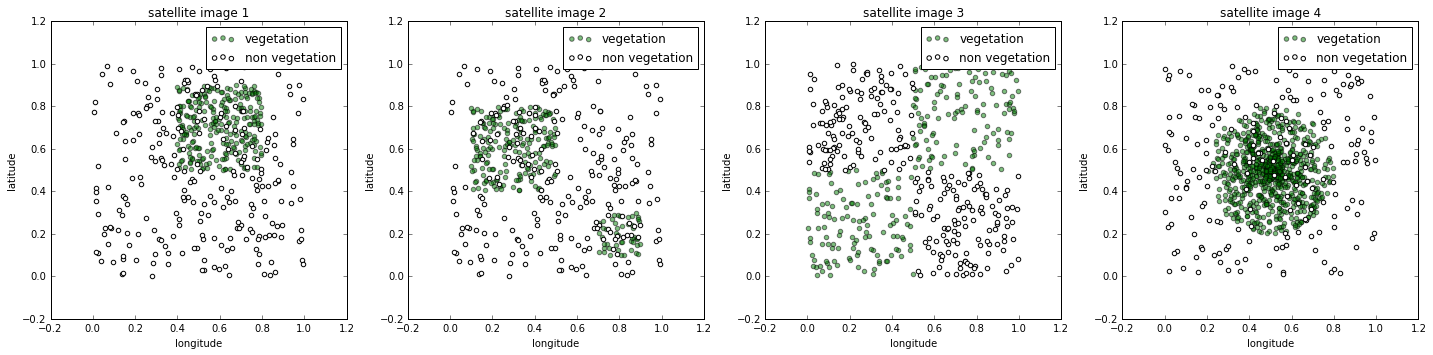

In [4]:
# Plot the data in each dataframe as a subplot of a single figure
# ----------------------------------------------------------------

fig, ax = plt.subplots(1, 4, figsize=(20, 5))

#Iterate through the four images/dataframes
for i in range(4):
    #Get the long/lat coords
    x = sat_images[i].values[:, :-1]
    #Get the class labels
    y = sat_images[i].values[:, -1]
    
    #Plot vegetation locations as green dots
    ax[i].scatter(x[y == 1, 0], x[y == 1, 1], c='green', label='vegetation', alpha = 0.5)
    #Plot non-vegetation locations as white dots
    ax[i].scatter(x[y == 0, 0], x[y == 0, 1], c='white', label='non vegetation')
    
    #Label everything
    ax[i].set_xlabel('longitude')
    ax[i].set_ylabel('latitude')
    ax[i].set_title('satellite image {}'.format(i + 1))
    ax[i].legend()
    
plt.tight_layout()
plt.show() 

#### Models to be considered:

Based on the shape of the class data and the anticipated boundary of each class, a linear regression does not seem to be superior to other classification method. However, if the linear classifier proves to be adequate in the forthcoming analysis, the linear regression will be considered. For the time been, the methods that will be considered are:

 - Linear or Polynomial Logistic Regression
 - Linear or Quadratic Descriminant Analysis
 - Decision Tree

** Useful Functions:**

<br>

In [5]:
# Function to plot Decision Boundary :
# ------------------------------------

def plot_decision_boundary(x, y, model, title, ax, bounds=(0, 1), poly_flag=False):
    # Plot data
    ax.scatter(x[y == 1, 0], x[y == 1, 1], c='green')
    ax.scatter(x[y == 0, 0], x[y == 0, 1], c='white')
    
    # Create mesh
    interval = np.arange(bounds[0], bounds[1], 0.01)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1, 1)
    x2 = x2.reshape(-1, 1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh points
    if(poly_flag):
        quad_features = preprocessing.PolynomialFeatures(degree=2)
        xx = quad_features.fit_transform(xx)
        
    yy = model.predict(xx)    
    yy = yy.reshape((n, n))

    # Plot decision surface
    x1 = x1.reshape(n, n)
    x2 = x2.reshape(n, n)
    ax.contourf(x1, x2, yy, alpha=0.1, cmap='Greens')
    
    # Label axes, set title
    ax.set_title(title)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    
    return ax

In [6]:
# Function to plot decision tree boundaries:
# ------------------------------------------

def plot_tree_boundary(x, y, model, title, ax):
    # PLOT DATA
    ax.scatter(x[y==1,0], x[y==1,1], c='green')
    ax.scatter(x[y==0,0], x[y==0,1], c='white')
    
    # CREATE MESH
    interval = np.arange(0,1,0.01)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1,1)
    x2 = x2.reshape(-1,1)
    xx = np.concatenate((x1, x2), axis=1)

    # PREDICT ON MESH POINTS
    yy = model.predict(xx)    
    yy = yy.reshape((n, n))

    # PLOT DECISION SURFACE
    x1 = x1.reshape(n, n)
    x2 = x2.reshape(n, n)
    ax.contourf(x1, x2, yy, alpha=0.1, cmap='Greens')
    
    # LABEL AXIS, TITLE
    ax.set_title(title)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    
    return ax

In [7]:
# Function to fit and plot Decision Tree Boundaries:
# --------------------------------------------------

def fit_and_plot_dt(x, y, depth, title, ax , spl):
    # FIT DECISION TREE MODEL
    dt = tree.DecisionTreeClassifier(max_depth = depth , splitter = spl)
    dt.fit(x, y)

    # PLOT DECISION TREE BOUNDARY
    ax = plot_tree_boundary(x, y, dt, title, ax)
    
    return ax

** 1. Linear Logitic Regression:**

<br>

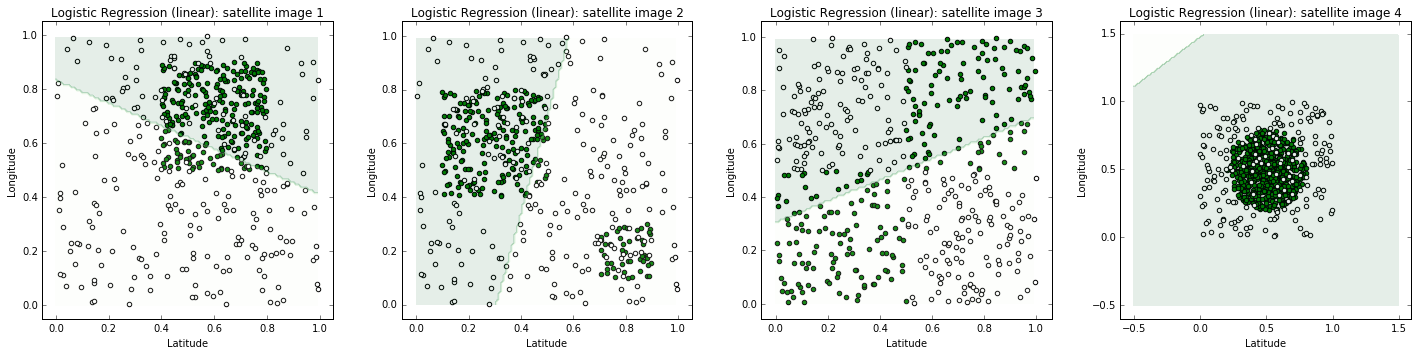

In [8]:
#Plot the data in each dataframe as a subplot of a single figure
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

#Create a logistic regression model with linear boundary
logreg = linear_model.LogisticRegression()

#Iterate through the four images/dataframes
for i in range(4):
    #Get the long/lat coords
    x = sat_images[i].values[:, :-1]
    #Get the class labels
    y = sat_images[i].values[:, -1]    
    
    #Fit our logistic regression model
    logreg.fit(x, y)
    
    #Change the bounds on the scatter plot (the 4th dataframe needs a larger frame)
    if i == 3:
        bounds = (-0.5, 1.5)
    else:
        bounds = (0, 1)
    
    #Plot the data along with the decision boundary learned by our model
    ax[i] = plot_decision_boundary(x, y, logreg, 
                                   'Logistic Regression (linear): satellite image {}'.format(i + 1), 
                                   ax[i], bounds)
    

plt.tight_layout()
plt.show()

** 2. Quadratic Logistic Regresssion:**

<br>

a- C = 1

<br>

[[-1.39172891  1.71654454  2.58971343 -2.02119606  3.66010959 -0.58789771]]
[[-0.06581677  0.13566135  2.50682679 -0.8228054  -2.43063731 -1.49636006]]
[[ 0.55752621 -2.0035268  -2.3613162  -1.64231161  7.63470148 -0.98608633]]
[[ 0.24796506  3.93437296  2.77580053 -5.07187077  1.7680691  -5.12608963]]


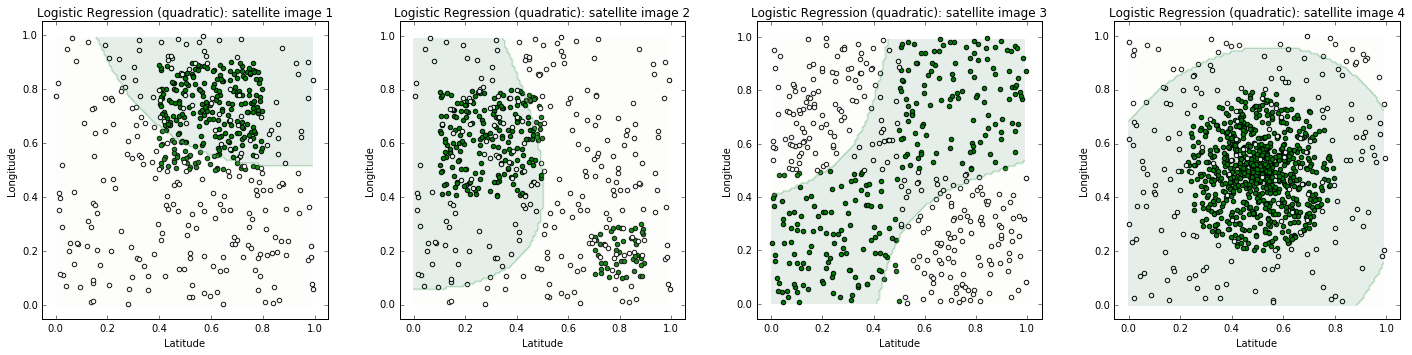

In [9]:
#Plot the data in each dataframe as a subplot of a single figure
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

#Logistic Regression with Quadratic Terms
logreg_poly = linear_model.LogisticRegression(C=1)

#Iterate through the four images/dataframes
for i in range(4):
    #Get the long/lat coords
    x = sat_images[i].values[:, :-1]
    #Get the class labels
    y = sat_images[i].values[:, -1]  
    
    #Expand our predictor array with quadratic terms
    quad_features = preprocessing.PolynomialFeatures(degree = 2)
    x_expanded = quad_features.fit_transform(x)
    
    #Fit logistic regression model with quadratic decision boundary
    logreg_poly.fit(x_expanded, y)
    print logreg_poly.coef_
    
    #Plot the data along with the decision boundary learned by our model
    ax[i] = plot_decision_boundary(x, y, logreg_poly, 'Logistic Regression (quadratic): satellite image {}'.format(i + 1), ax[i], poly_flag=True)
    

plt.tight_layout()
plt.show()

b- C = 10000000


<br>

[[-19.50540101  55.93062075  71.56926155 -57.2587467   18.98500493
  -58.39486041]]
[[ -7.2655985   26.57293922  42.00190582 -13.02830001 -35.11515279
  -26.74445167]]
[[  540.33670379 -2164.6239243  -2161.04223506    17.01327085
   4306.39387195     6.82293428]]
[[ -8.68859329  47.15056235  41.93014174 -47.47374215   0.70668885
  -43.63534033]]


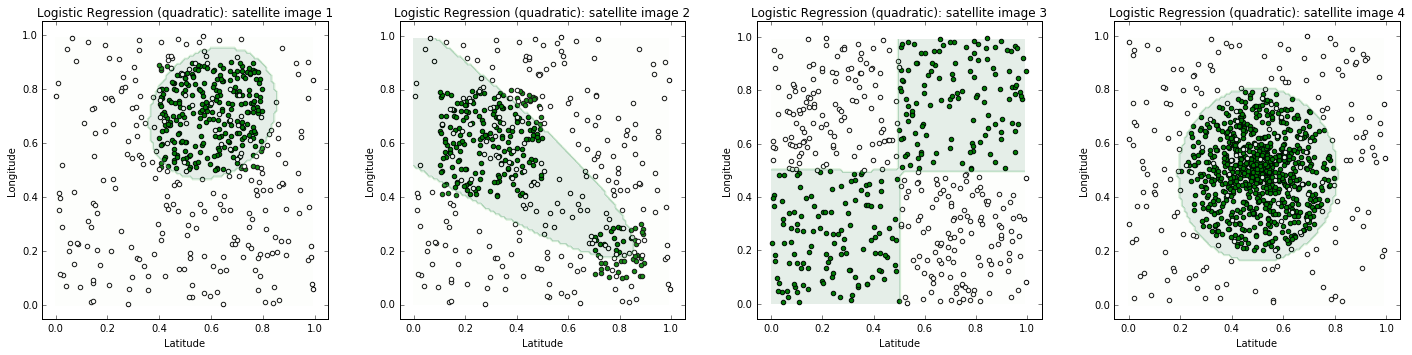

In [10]:
#Plot the data in each dataframe as a subplot of a single figure
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

#Logistic Regression with Quadratic Terms
logreg_poly = linear_model.LogisticRegression(C=10000000)

#Iterate through the four images/dataframes
for i in range(4):
    #Get the long/lat coords
    x = sat_images[i].values[:, :-1]
    #Get the class labels
    y = sat_images[i].values[:, -1]  
    
    #Expand our predictor array with quadratic terms
    quad_features = preprocessing.PolynomialFeatures(degree = 2)
    x_expanded = quad_features.fit_transform(x)
    
    #Fit logistic regression model with quadratic decision boundary
    logreg_poly.fit(x_expanded, y)
    print logreg_poly.coef_
    
    #Plot the data along with the decision boundary learned by our model
    ax[i] = plot_decision_boundary(x, y, logreg_poly, 'Logistic Regression (quadratic): satellite image {}'.format(i + 1), ax[i], poly_flag=True)
    

plt.tight_layout()
plt.show()

** 3. Linear Descriminant Analysis:**

<br>

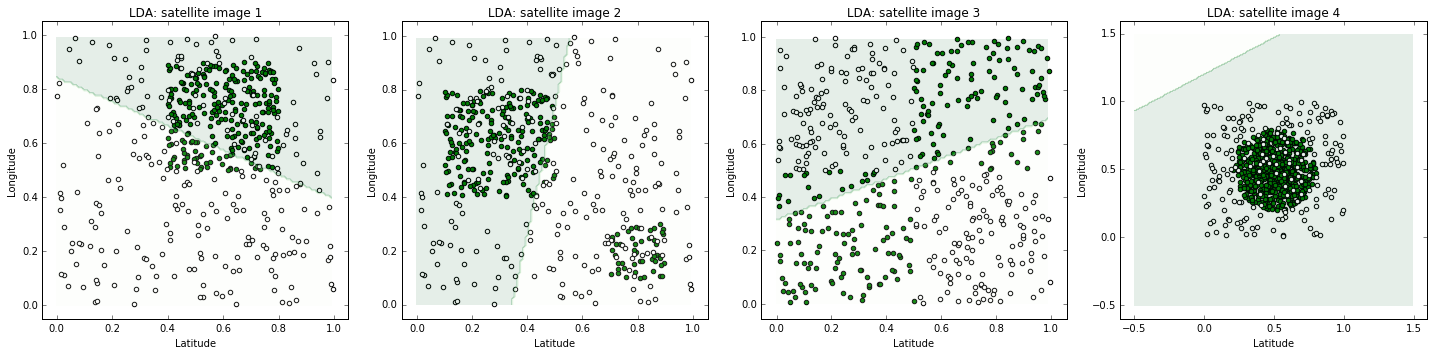

In [11]:
#Plot the data in each dataframe as a subplot of a single figure
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

# LDA
lda = discriminant_analysis.LinearDiscriminantAnalysis()

#Iterate through the four images/dataframes
for i in range(4):
    #Get the long/lat coords
    x = sat_images[i].values[:, :-1]
    #Get the class labels
    y = sat_images[i].values[:, -1]  
    
    #Fit our LDA model
    lda.fit(x, y)
    
    #Change the bounds on the scatter plot (the 4th dataframe needs a larger frame)
    if i == 3:
        bounds = (-0.5, 1.5)
    else:
        bounds = (0, 1)
        
    #Plot the data along with the decision boundary learned by our model    
    ax[i] = plot_decision_boundary(x, y, lda, 'LDA: satellite image {}'.format(i + 1), ax[i], bounds)
    

plt.tight_layout()
plt.show()

** 4. Quadratic Descriminant Analysis:**

<br>

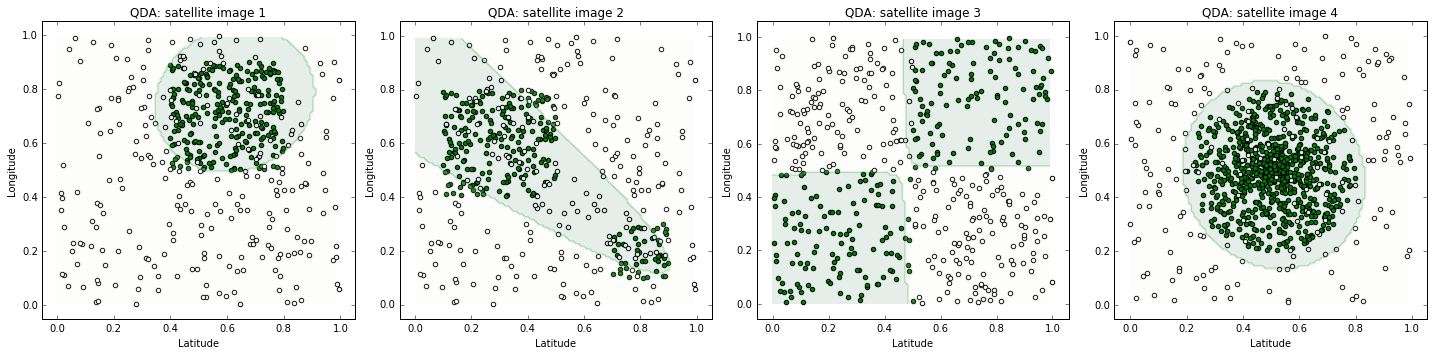

In [12]:
#Plot the data in each dataframe as a subplot of a single figure
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

#Logistic Regression with Quadratic Terms
qda = discriminant_analysis.QuadraticDiscriminantAnalysis(reg_param = 0.0)

#Iterate through the four images/dataframes
for i in range(4):
    #Get the long/lat coords
    x = sat_images[i].values[:, :-1]
    #Get the class labels
    y = sat_images[i].values[:, -1]  
    
    #Fit our QDA model
    qda.fit(x, y)
        
    #Plot the data along with the decision boundary learned by our model 
    ax[i] = plot_decision_boundary(x, y, qda, 'QDA: satellite image {}'.format(i + 1), ax[i])
    

plt.tight_layout()
plt.show()

** 5. Decision Tree with depth  = 5:**

<br>

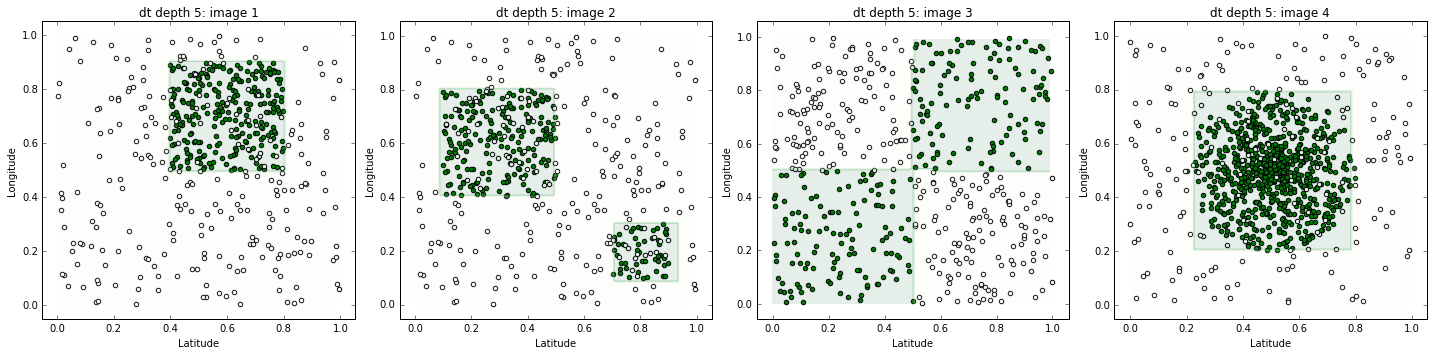

In [13]:
#Plot the data in each dataframe as a subplot of a single figure
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

#Logistic Regression with Quadratic Terms
dt = tree.DecisionTreeClassifier(max_depth = 5)

#Iterate through the four images/dataframes
for i in range(4):
    #Get the long/lat coords
    x = sat_images[i].values[:, :-1]
    #Get the class labels
    y = sat_images[i].values[:, -1]  
    
    #Fit our QDA model
    dt.fit(x, y)
        
    #Plot the data along with the decision boundary learned by our model 
    ax[i] = plot_decision_boundary(x, y, dt, 'dt depth 5: image {}'.format(i + 1), ax[i])
    

plt.tight_layout()
plt.show()

**Conclusion:**

From th above visualizations the following can be deduced:

 - Based on the data scatter shape it can be deduced that the linear models will not perform well and this was obvious for the linear logistic regression and the LDA. Accordingly no further analysis for the linear regression will be conducted.
 - All the quadratic models have a satifactory performance based on the fact of the adaptability of the decision boundary
 - The quadratic descrimnant analysis model was able to encircle and hence efficiently confine the vegetation class in dataset 4 were the vegetation area is circular and the same is applicable for first dataset where the vegetation class is also closed. For the second data set its performance was within the limitation of its quadratic nature and the entailed flexibility. The third dataset, it was able to create a reasonable decision boundary curve which is flexible enough to output a reasonable classification
 - The logistic regression with quadratic terms has a performance comparable to the quadratic descriminant for datasets 2,3 and 4. However it was better for the first dataset compared to the quadratic descriminant. The reason for this improvment is the data distribution. Having a rectangular shape, it is not close to a multivariate normal distribution and hence the logistic regression was better in this case. 
 - The decision tree worked perfectly for datasets 1 , 2 and 3. Specifying a maximum depth of 5, the decision tree was correctly capable to capture the vegetation class boundary. The main reason is that the decision boundaries orientation is lining perfectly with the feature space splits of the decision tree. However, for the last dataset and based on its circular shape, the maximum depth felt short to capture the actual vegetation boundaries. Theoriticaly, an infinite number of rectangular boundaries is needed to achiev the high level of classification experienced with the other data sets. More analysis on selecting the tree parameters for each dataset is in the following section

**6. Decision tree parameters:**

<br>

The purpose of this analysis is to define the best parameters (depth and splitter) for each dataset


Solution Strategy:

- For each dataset we will try different depth
- the best depth out of the trial will be selected
- For this depth both splitter methods will be tested
- For the last dataset we will explore higher depth to investigate if the classification will improve or not.

<br>

** First Dataset:**

<br>

 a. Best Depth:
 
<br>

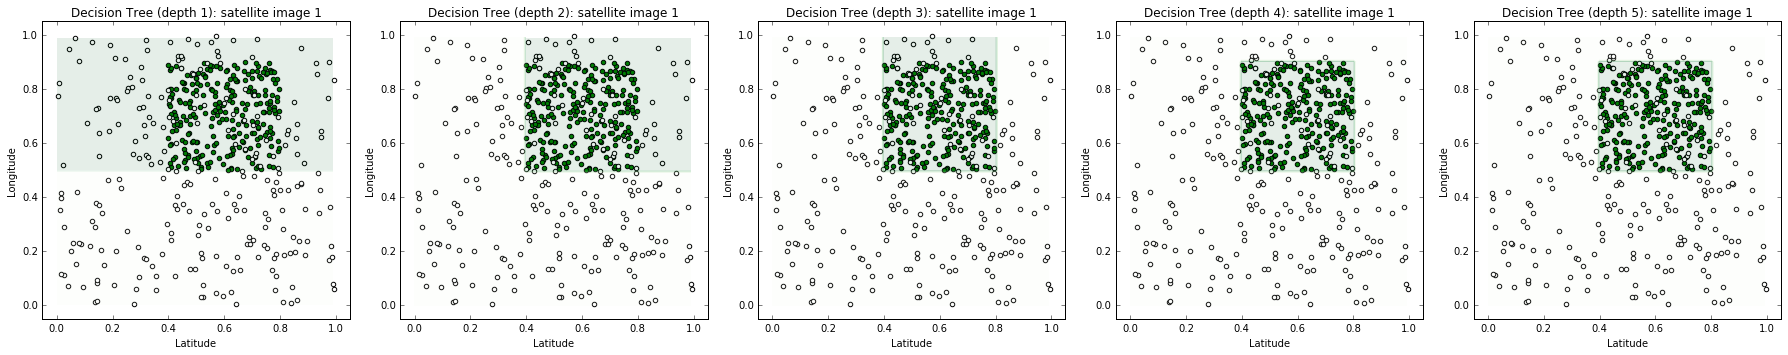

In [14]:
# Plot for dataset_1.txt: depths 1 to 5
fig, ax = plt.subplots(1, len(range(1, 6)), figsize=(25, 5))
#Get the long/lat coords
x = sat_images[0].values[:, :-1]
#Get the class labels
y = sat_images[0].values[:, -1]

#Set an index for the subplots
ind = 0
#Iterate through various depths
for i in range(1, 6):
    #Plot data and decision boundary for decision tree model
    ax[ind] = fit_and_plot_dt(x, y, i, 'Decision Tree (depth {}): satellite image 1'.format(i), ax[ind], 'best') 
    #Increment subplot index
    ind += 1

plt.tight_layout()
plt.show()

 b. Compare both splitting methods:
 
<br>

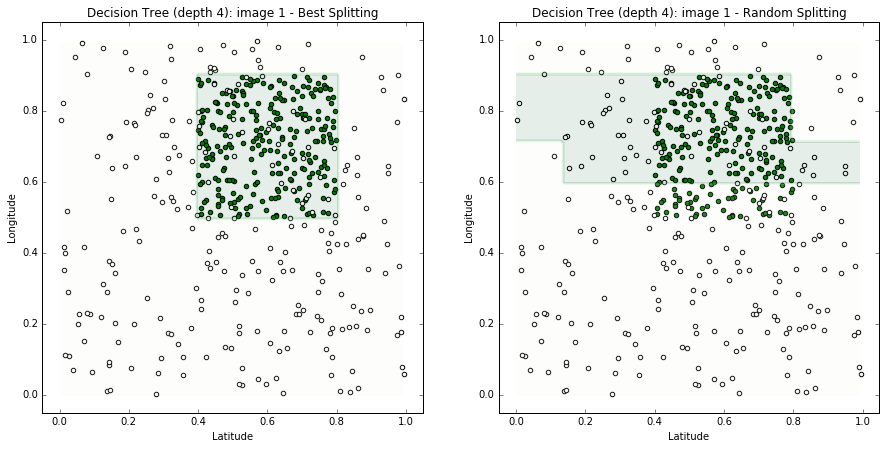

In [15]:
# Acquire the data
x = sat_images[0].values[:, :-1]

#Get the class labels
y = sat_images[0].values[:, -1]

# Figure initiation
fig = plt.figure(figsize = (15,7))

# First Splitting method
ax1 = fig.add_subplot(121)
ax1 = fit_and_plot_dt(x, y, 4, 'Decision Tree (depth {}): image 1 - Best Splitting'.format(4), 
                      ax1, 'best')

# Second Splitting Method
ax1 = fig.add_subplot(122)
ax1 = fit_and_plot_dt(x, y, 4, 'Decision Tree (depth {}): image 1 - Random Splitting'.format(4),
                      ax1, 'random')

plt.show()

<br>

**Second Dataset:**

<br>

 a. Best Depth:
 
<br>

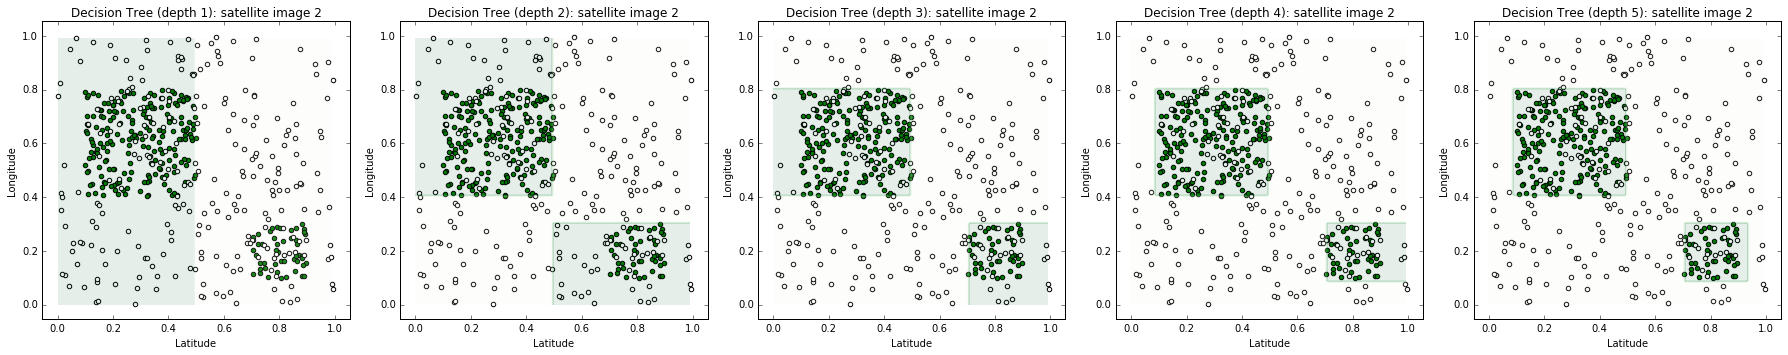

In [16]:
# Plot for dataset_1.txt: depths 1 to 5
fig, ax = plt.subplots(1, len(range(1, 6)), figsize=(25, 5))
#Get the long/lat coords
x = sat_images[1].values[:, :-1]
#Get the class labels
y = sat_images[1].values[:, -1]

#Set an index for the subplots
ind = 0
#Iterate through various depths
for i in range(1, 6):
    #Plot data and decision boundary for decision tree model
    ax[ind] = fit_and_plot_dt(x, y, i, 'Decision Tree (depth {}): satellite image 2'.format(i), ax[ind], 'best') 
    #Increment subplot index
    ind += 1

plt.tight_layout()
plt.show()

 b. Compare both splitting methods:
 
<br>

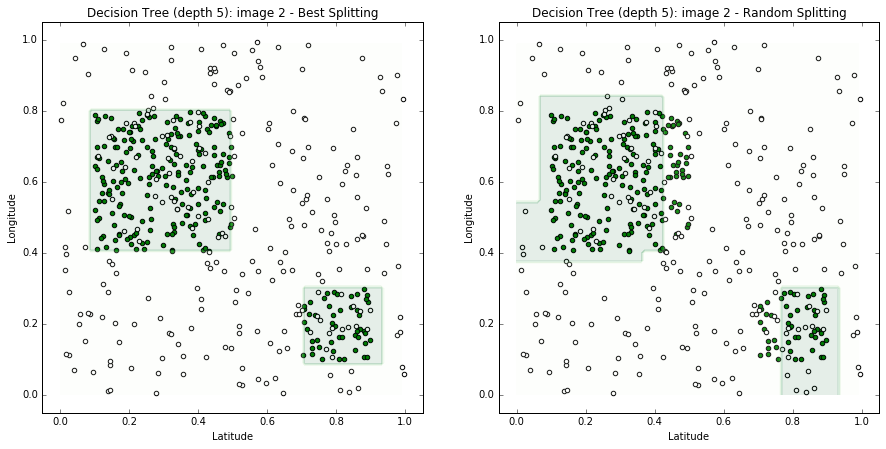

In [17]:
# Acquire the data
x = sat_images[1].values[:, :-1]

#Get the class labels
y = sat_images[1].values[:, -1]

# Figure initiation
fig = plt.figure(figsize = (15,7))

# First Splitting method
ax1 = fig.add_subplot(121)
ax1 = fit_and_plot_dt(x, y, 5, 'Decision Tree (depth {}): image 2 - Best Splitting'.format(5), 
                      ax1, 'best')

# Second Splitting Method
ax1 = fig.add_subplot(122)
ax1 = fit_and_plot_dt(x, y, 5, 'Decision Tree (depth {}): image 2 - Random Splitting'.format(5),
                      ax1, 'random')

plt.show()

<br>

**Third Dataset:**

<br>

 a. Best Depth:
 
<br>

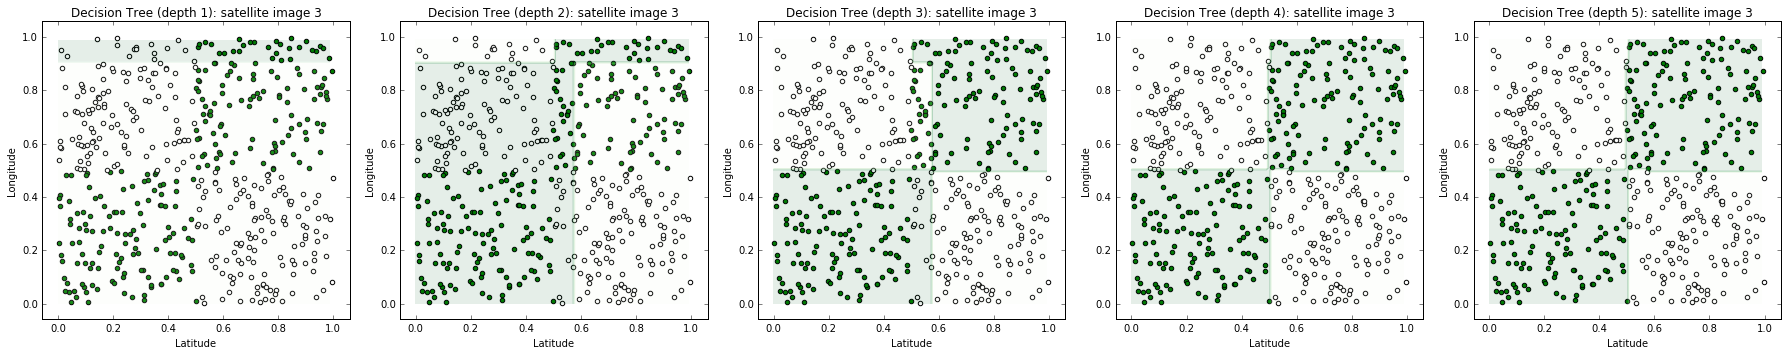

In [18]:
# Plot for dataset_1.txt: depths 1 to 5
fig, ax = plt.subplots(1, len(range(1, 6)), figsize=(25, 5))
#Get the long/lat coords
x = sat_images[2].values[:, :-1]
#Get the class labels
y = sat_images[2].values[:, -1]

#Set an index for the subplots
ind = 0
#Iterate through various depths
for i in range(1, 6):
    #Plot data and decision boundary for decision tree model
    ax[ind] = fit_and_plot_dt(x, y, i, 'Decision Tree (depth {}): satellite image 3'.format(i), ax[ind], 'best') 
    #Increment subplot index
    ind += 1

plt.tight_layout()
plt.show()

 b. Compare both splitting methods:
 
<br>

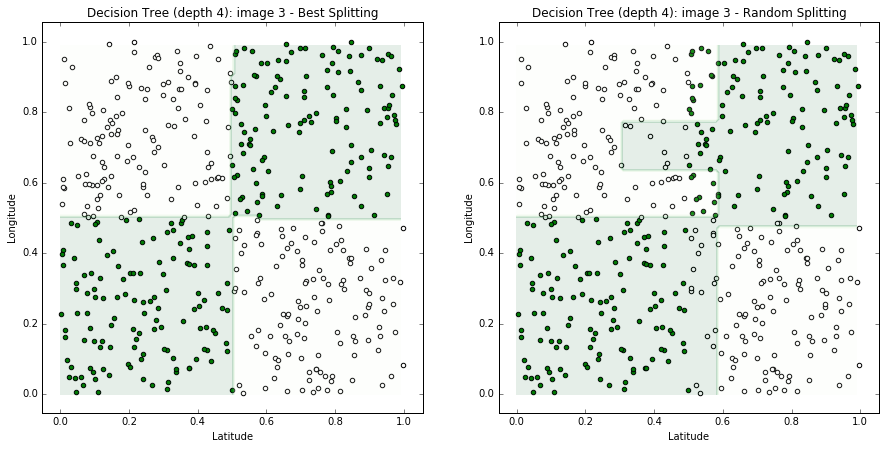

In [19]:
# Acquire the data
x = sat_images[2].values[:, :-1]

#Get the class labels
y = sat_images[2].values[:, -1]

# Figure initiation
fig = plt.figure(figsize = (15,7))

# First Splitting method
ax1 = fig.add_subplot(121)
ax1 = fit_and_plot_dt(x, y, 4, 'Decision Tree (depth {}): image 3 - Best Splitting'.format(4), 
                      ax1, 'best')

# Second Splitting Method
ax1 = fig.add_subplot(122)
ax1 = fit_and_plot_dt(x, y, 4, 'Decision Tree (depth {}): image 3 - Random Splitting'.format(4),
                      ax1, 'random')

plt.show()

<br>

**Fourth Dataset:**

<br>

 a. Best Depth:
 
<br>

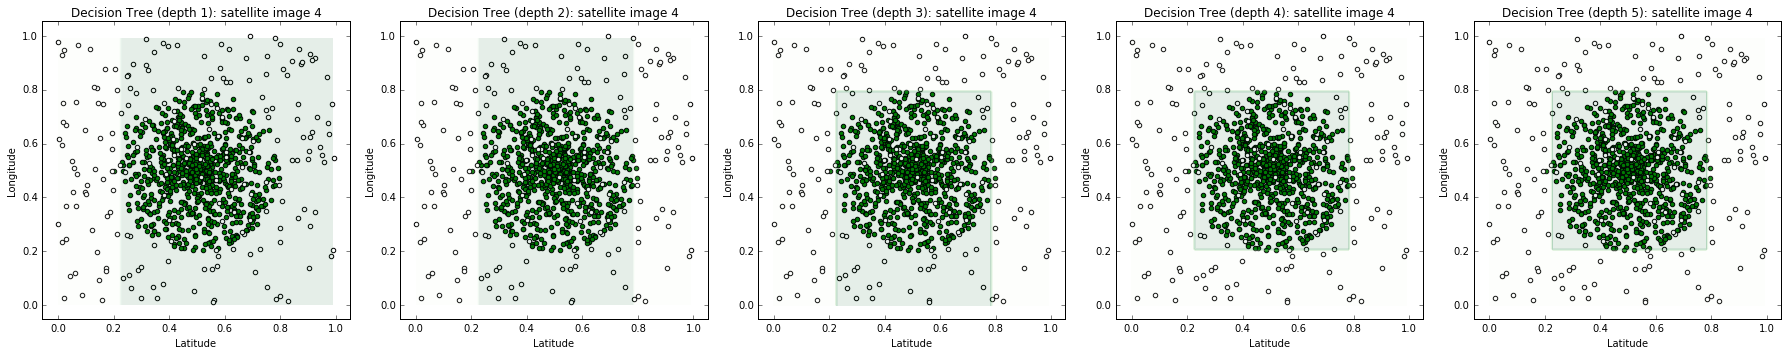

In [20]:
# Plot for dataset_1.txt: depths 1 to 5
fig, ax = plt.subplots(1, len(range(1, 6)), figsize=(25, 5))
#Get the long/lat coords
x = sat_images[3].values[:, :-1]
#Get the class labels
y = sat_images[3].values[:, -1]

#Set an index for the subplots
ind = 0
#Iterate through various depths
for i in range(1, 6):
    #Plot data and decision boundary for decision tree model
    ax[ind] = fit_and_plot_dt(x, y, i, 'Decision Tree (depth {}): satellite image 4'.format(i), ax[ind], 'best') 
    #Increment subplot index
    ind += 1

plt.tight_layout()
plt.show()

 b. Compare both splitting methods:
 
<br>

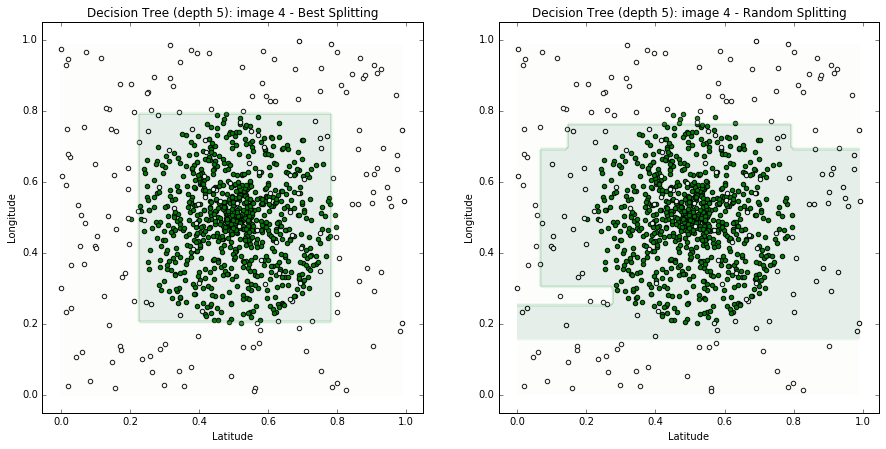

In [21]:
# Acquire the data
x = sat_images[3].values[:, :-1]

#Get the class labels
y = sat_images[3].values[:, -1]

# Figure initiation
fig = plt.figure(figsize = (15,7))

# First Splitting method
ax1 = fig.add_subplot(121)
ax1 = fit_and_plot_dt(x, y, 5, 'Decision Tree (depth {}): image 4 - Best Splitting'.format(5), 
                      ax1, 'best')

# Second Splitting Method
ax1 = fig.add_subplot(122)
ax1 = fit_and_plot_dt(x, y, 5, 'Decision Tree (depth {}): image 4 - Random Splitting'.format(5),
                      ax1, 'random')

plt.show()

 c. Explore higher depths:
 
<br>

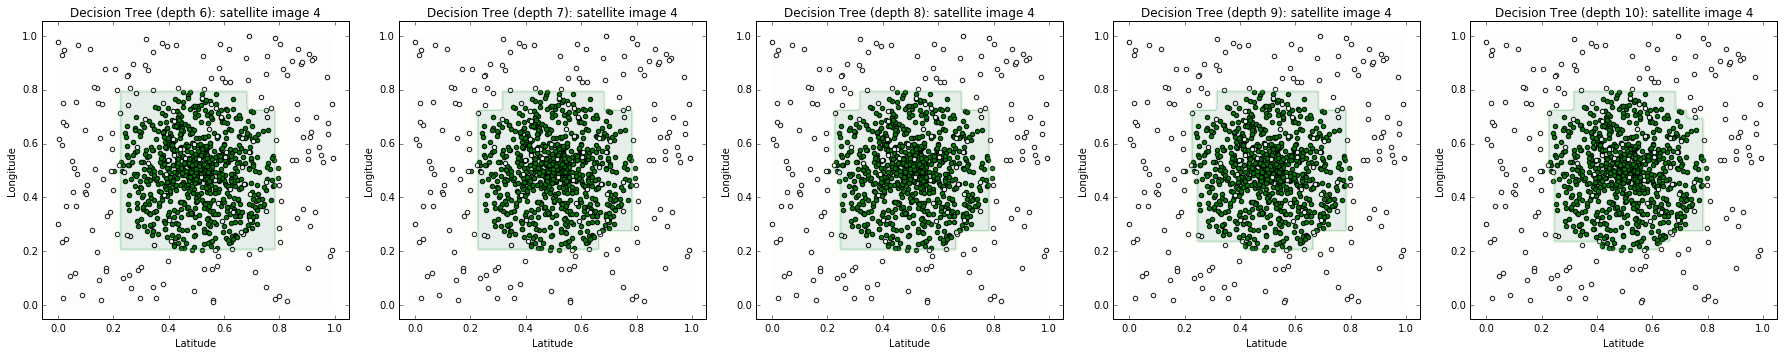

In [22]:
# Plot for dataset_1.txt: depths 1 to 5
fig, ax = plt.subplots(1, len(range(1, 6)), figsize=(25, 5))
#Get the long/lat coords
x = sat_images[3].values[:, :-1]
#Get the class labels
y = sat_images[3].values[:, -1]

#Set an index for the subplots
ind = 0
#Iterate through various depths
for i in range(6, 11):
    #Plot data and decision boundary for decision tree model
    ax[ind] = fit_and_plot_dt(x, y, i, 'Decision Tree (depth {}): satellite image 4'.format(i), ax[ind], 'best') 
    #Increment subplot index
    ind += 1

plt.tight_layout()
plt.show()

**Conclusion:**

<br>

From the above visualizations, the following can be deduced:

 - Tree depth:

  - The appropiate depth of the tree depends on the class data shape. For the first and third dataset a depth of four was enough to well seperate the data with no major misclassifcation.
  - For the the second dataset, a level of 5 was adequate for the decision tree depth in order to give a disent classification. This is due to the fact that the vegetation class is not confined in one area in the feature space like the previous case.
  - For the fourth dataset and based on the fact that the class is circular, an infinite number of splits should capture the exact contour of the class in a comparable fashion to the qudratic classifiers. 
  - However, based on the fact that the decision tree splits consider each variable individually at each split, capturing the exact shape of a class cannot be garanteed. 
  - Both variables should be simultaneously considered during the split and not individual variables in order to achieve a nice contour. 
  - In this case, increasing the the number of splits will not increase the resolution of the decision boundary. 
  - For this purpose a depth of five achieves a good vegetation class confinement with reasonable miss classification error

 - Splitting method:

  - The above analysis demonstrated that the best splitting method is "best" which is based on the greedy algorithm.
  - This method was giving a more consistent decision boundary in agreement with the actual class shape and less miss classification. 
  - The "random" method is usually producing a rugged decision boundary with a considerable amount of mis classification
  - sklearn default setup is the "best" method.

### Part 1(b). What is the best splitting criterion for decision trees?
Suppose you are given a data set with 100 points in a satellite image, of which 51 are class 1 and 49 are class 0. Consider following two candidate splits for constructing a decision tree: 
1. [Part 1 = (Class 1: 11, Class 0: 37), Part 2 = (Class 1: 40, Class 0: 12)]
2. [Part 1 = (Class 1: 25, Class 0: 48), Part 2 (Class 1: 26, Class 0: 1)]

Which of these is a better split according classification error, Gini coefficient, and Entropy criteria? Do the three criteria agree on the best split, or is one better than the other? Support your answer with a concrete explanation.

In [23]:
# Functions for classification error , Gini and entropy:
# -----------------------------------------------------

# Calculate classification accuracy for a binary split
def err(p1, p2):
    return min((p1,p2))

# Calculate Gini coefficient for a binary split
def Gini(p1, p2):
    return p1*(1-p1) + p2*(1-p2)

# Calculate Cross-entropy for a binary split
def entropy(p1, p2):
    return -p1*np.log(p1) - p2*np.log(p2)



# First Case:
# ----------

# Elements first partition (0 - dominant)
n11 = 48

# Elements Second partition (1 - dominant)
n12 = 52

# Total Elements
n1 = n11 + n12

# Probability of "1" in first partition
x1 = 11./n11

# Probability of "0" in first partition
x2 = 37./n11

# Probability of "1" in second partition
y1 = 40./n12

# Probabilty of "0" in second partition
y2 = 12./n12


# print results (weighted average of error, Gini, Entropy fo both partitions):
print '\nSplit 1:'
print 'Error =     ' , str((n11*err(x1,x2)+n12*err(y1,y2))/n1) 
print 'Gini =      ' , str((n11*Gini(x1,x2)+n12*Gini(y1,y2))/n1)
print 'Entropy =   ' , str((n11*entropy(x1,x2)+n12*entropy(y1,y2))/n1)
print ' '


# Second Case:
# -----------

# Elements first partition (0 - dominant)
n11 = 73

# Elements Second partition (1 - dominant)
n12 = 27

# Total Elements
n1 = n11 + n12

# Probability of "1" in first partition
x1 = 25./n11

# Probability of "0" in first partition
x2 = 48./n11

# Probability of "1" in second partition
y1 = 26./n12

# Probabilty of "0" in second partition
y2 = 1./n12


# print results (weighted average of error, Gini, Entropy fo both partitions):
print '\nSplit 2:'
print 'Error =     ' , str((n11*err(x1,x2)+n12*err(y1,y2))/n1) 
print 'Gini =      ' , str((n11*Gini(x1,x2)+n12*Gini(y1,y2))/n1)
print 'Entropy =   ' , str((n11*entropy(x1,x2)+n12*entropy(y1,y2))/n1)
print ' '


Split 1:
Error =      0.23
Gini =       0.354198717949
Entropy =    0.539274531592
 

Split 2:
Error =      0.26
Gini =       0.348026382547
Entropy =    0.511910804521
 


**Conclusion:**

Based on the results above, we can conclude the following:

 - The classification error is smaller for the first method while both the Gini and entropy are higher for the second method indicating more pure classes
 - Based on the above, the Gini or entropy are more convenient criteria for the split
 - The default for sklearn is Gini. It supports also the entropy. The error is not considered as a critera option
 
<br>

**Investigating both options for the four satelite images:**

<br>

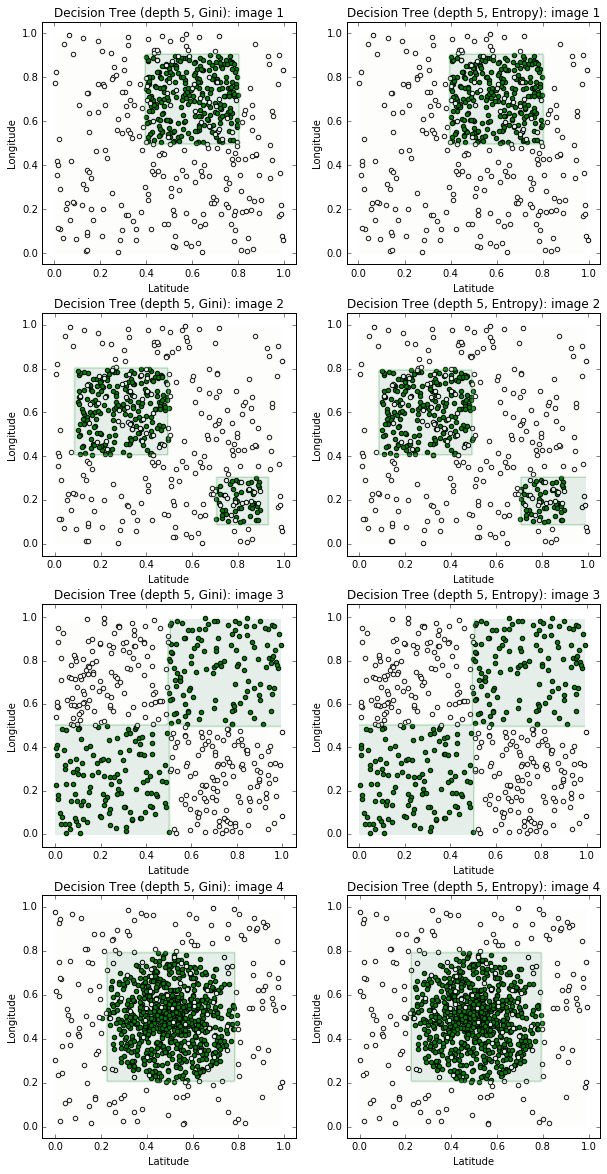

In [24]:
# Compare between the Gini and Entropy for split criteria:
# -------------------------------------------------------

# Figure initiation
fig = plt.figure(figsize = (10,20))


# Decision tree for each image for each criteria
for i in range (4):
    
    # Subplots
    ax1 = fig.add_subplot(4,2,2 * ( i + 1) - 1)
    ax2 = fig.add_subplot(4,2, 2 * (i+1))
    
    # Acquire the data
    x = sat_images[i].values[:, :-1]
    
    #Get the class labels
    y = sat_images[i].values[:, -1]

    ## First Criteria
    # decision tree
    dt = tree.DecisionTreeClassifier(max_depth = 5 , criterion='gini')
    dt.fit(x, y)
    # boundary plot
    ax1 = plot_tree_boundary(x, y, dt, 'Decision Tree (depth 5, Gini): image {}'.format(i+1), ax1)

    ## Second criteria
    # decision tree
    dt = tree.DecisionTreeClassifier(max_depth = 5 , criterion='entropy')
    dt.fit(x, y)
    # boundary plot
    ax2 = plot_tree_boundary(x, y, dt, 'Decision Tree (depth 5, Entropy): image {}'.format(i+1), ax2)

plt.show()

**Conclusion:**

 - Fundmentaly, the two options lead to very close results for most of the images
 - An exception can be seen for the second image where the Gini was performing slightly better than the entropy for the class with fewer population
 - A possible reason could be the difference between the effect of the product in the Gini and exponent in the entropy on the split criteria for smaller classes
 
<br>

## Problem 2: Loan Risk Assessment
In this problem, you are asked by an Unamed National Bank to build a risk assessment model that predicts whether or not it is risky to give a loan to an applicant based on the information provided in their application. Traditionally, loan applications are processed and assessed by hand, but now the bank wants to move to an automated loan processing system. That is, the bank will provide you with loan applications that it has processed in the past for you to build a classifier for risk assessment, going forward, the bank will reject the loan applications from applicants labeled risky and approve the applications that are labeled safe by your model.

The relevant training and test sets are provided in the files: `dataset_5_train.txt` and `dataset_5.test.txt`. The training and testing sets are created from both approved and rejected loan applications that the bank has processed by hand in the past. The first 24 columns contain attributes for each applicant gathered from their application, and the last column contains the credit risk assessment with 1 indicating that the customer is a loan risk, and 0 indicating that the customer is not a loan risk. The names of the attributes are provided in the file `dataset_5_description.txt`.


### Part 2(a): A simple decision tree model
- Fit a simple decision tree of depth 2 to the training set and report its accuracy on the test set. 

- Interpret the way your model performs risk classifcation. Would you recommend this classifier to Unamed National Bank for making decisions on the loan applications of **real people**? If yes, make an argument for the merrits of this classifer. If no, then make necessary changes to the data set and fit a new classifier that you believe is fair to use in practice, then compare the two classifiers.


We have provided you with a function `display_dt` to display the structure of the decision tree in DOT format.

In [138]:
# Print decision tree model 'model', already fitted
def display_dt(model):
    dummy_io = StringIO.StringIO() 
    tree.export_graphviz(dt, out_file = dummy_io) 
    print dummy_io.getvalue()

<font color = 'blue'>
### Solution:
</font>
<br>

#### 1. Data Investigation:

<br>

In [93]:
# Open the train and test dataset:
# -------------------------------

# training set
train_raw = pd.read_csv('datasets/dataset_5_train.txt' , header = None)

# test set
test_raw = pd.read_csv('datasets/dataset_5_test.txt', header = None)

# Explanation table
ex_table = pd.read_csv('datasets/dataset_5_description.txt', skiprows = 12 , delimiter = '\t')

# Eplanation Text
ex_text = pd.read_csv('datasets/dataset_5_description.txt', delimiter = ':', skiprows = range(11,26))
train_raw.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,3288.0,20000.0,2.0,1.0,2.0,39.0,0.0,0.0,0.0,0.0,...,19308.0,19498.0,0.0,1588.0,1770.0,1200.0,390.0,0.0,44334.0,1.0
1,3001.0,50000.0,1.0,2.0,2.0,27.0,2.0,2.0,0.0,0.0,...,7382.0,1975.0,50514.0,4146.0,1200.0,0.0,0.0,49800.0,0.0,1.0
2,3288.0,80000.0,1.0,2.0,2.0,27.0,1.0,2.0,2.0,2.0,...,68531.0,69808.0,70544.0,5000.0,3100.0,2000.0,3000.0,2000.0,4000.0,1.0
3,3652.0,70000.0,2.0,2.0,2.0,22.0,0.0,0.0,0.0,0.0,...,69316.0,29083.0,28140.0,3200.0,3600.0,3075.0,1204.0,1200.0,1046.0,0.0
4,3817.0,200000.0,1.0,1.0,2.0,24.0,-1.0,-1.0,-1.0,-1.0,...,18154.0,13677.0,2018.0,200.0,198.0,18156.0,0.0,1150.0,0.0,0.0


In [108]:
# Description:
# ------------

ex_text.style

In [147]:
# Categorical Variables investigation:
# ------------------------------------

# Array of categorical columns
cat_arr = np.array([0, 2, 3, 4, 6, 7, 8, 9, 10, 11])

# Array of categorical description (from the description dataframe)
cat_des = np.array([0, 2, 3, 4, 6, 6, 6, 6,  6,  6])

# Training data
print 'Training Data:'
print '-------------\n'

for i in range(len(cat_arr)):
    print '\ncolumn:  ' , cat_arr[i]
    if (i < 4) :
        print  'description criteria:' , ex_text.iloc[cat_des[i] , 1]
    else: print 'description criteria: [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]'
    print 'Actual training data:' , train_raw.iloc[:,cat_arr[i]].unique()

print '\n\n '

# Test data
print 'Test Data:'
print '-------------\n'

for i in range(len(cat_arr)):
    print '\ncolumn:  ' , cat_arr[i]
    if (i < 4) :
        print  'description criteria:' , ex_text.iloc[cat_des[i] , 1]
    else: print 'description criteria: [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]'
    print 'Actual test data:' , test_raw.iloc[:,cat_arr[i]].unique()

Training Data:
-------------


column:   0
description criteria:  Census code (3001; 3123; 3288; 3298; 3420; 3530; 3540; 3585; 3652; 3662; 3817; 3827)
Actual training data: [ 3288.  3001.  3652.  3817.  3298.  3530.  3420.  3585.  3827.  3123.
  3662.  3540.]

column:   2
description criteria:  Gender (1 = male; 2 = female).
Actual training data: [ 2.  1.]

column:   3
description criteria:  Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
Actual training data: [ 1.  2.  3.  4.  6.]

column:   4
description criteria:  Marital status (1 = married; 2 = single; 3 = others).
Actual training data: [ 2.  1.  3.]

column:   6
description criteria: [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Actual training data: [ 0.  2.  1. -1. -2.  3.]

column:   7
description criteria: [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Actual training data: [ 0.  2. -1. -2.  3.  6.  4.]

column:   8
description criteria: [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Actual training data: [ 0.  2. -1. -2.  3.  5.]

In [238]:
# Descripancies analysis:
# ----------------------

# discrepancies in training set

print '\nTraining inconsistencies:'

print 'number of inconsistent education  category 6 : ' , train_raw[3].loc[lambda s: s == 6.].count()
print 'At location:  ', train_raw[3].loc[lambda s: s == 6.].index.values


# Descrepancies of test set

print '\nTest inconsistencies'

test_0_3381 = test_raw[0].loc[lambda s: s == 3381.].index.values
print '\nnumber of inconsistent census code 3381 : ' , test_raw[0].loc[lambda s: s == 3381.].count()
print 'At location:  ', test_0_3381

test_3_0 = test_raw[3].loc[lambda s: s == 0.].index.values
print '\nnumber of inconsistent education 0 : ' , test_raw[3].loc[lambda s: s == 0.].count()
print 'At location:  ', test_3_0

test_3_5 = test_raw[3].loc[lambda s: s == 5.].index.values
print '\nnumber of inconsistent education 5 : ' , test_raw[3].loc[lambda s: s == 5.].count()
print 'At location:  ', test_3_5

test_3_6 = test_raw[3].loc[lambda s: s == 6.].index.values
print '\nnumber of inconsistent education 6 : ' , test_raw[3].loc[lambda s: s == 6.].count()
print 'At location:  ', test_3_6

test_4_0 = test_raw[4].loc[lambda s: s == 0.].index.values
print '\nnumber of inconsistent Marital Status 0 : ' , test_raw[4].loc[lambda s: s == 0.].count()
print 'At location:  ', test_4_0

# forming index array for test discrepancies
first = np.concatenate((test_0_3381 , np.concatenate((test_3_0, test_3_5))))
second = np.concatenate((test_3_6, test_4_0))
test_disc = np.unique(np.concatenate((first,second)))

# index array for train discrepancies
train_disc = train_raw[3].loc[lambda s: s == 6.].index.values

# percentage discrepancy:
percent_test = 100.0 * test_disc.shape[0] / test_raw.shape[0]
percent_train = 100.0 * train_disc.shape[0] / train_raw.shape[0]

print '\nTotal Training discrepancy percentage  : ' , percent_train
print '\nTotal Test discrepancy percentage:       ' , percent_test


Training inconsistencies:
number of inconsistent education  category 6 :  1
At location:   [228]

Test inconsistencies

number of inconsistent census code 3381 :  1
At location:   [3542]

number of inconsistent education 0 :  3
At location:   [3669 6144 8772]

number of inconsistent education 5 :  70
At location:   [  83  253  552  670  724 1065 1237 1244 1274 1400 1532 1618 1964 2254 2327
 2396 2422 2544 2557 2822 3130 3228 3363 3374 3510 3548 3549 3728 3853 4056
 4081 4082 4230 4539 4549 4776 4799 4842 4925 4982 5123 5188 5384 5386 5442
 5467 5472 5762 5846 6064 6072 6494 6711 6894 6900 7145 7274 7299 7584 7671
 8315 8470 8653 8691 8916 8925 9365 9550 9551 9600]

number of inconsistent education 6 :  14
At location:   [1753 2265 3165 5379 6899 7081 7208 7485 8127 8252 8529 8796 8821 9010]

number of inconsistent Marital Status 0 :  14
At location:   [ 565  768 1118 1318 3783 3874 4054 5390 7077 8031 8062 8775 8801 9364]

Total Training discrepancy percentage  :  0.4

Total Test disc

**Discussion:**

 - The number of discrepancies in the trainiing set is 1 row representing 0.4% of the data which can be neglected and hence it will be deleted from the dataset
 - The total number of discrepancies rows in the test dataset is 102 rows representing around 1% of the data
 - Since this is the test data and any imputation will not affect the model prediction accurracy. Inthis case we will impute them.

In [243]:
# Cleaned Data:
# --------------

# training
train = train_raw.drop(train_raw.index[train_disc])

# Test
test  = test_raw.drop(test_raw.index[test_disc])

### Part 2(b): An ensemble of decision trees

- One way to improve the prediciton accuracy for this task is to use an ensemble of decision trees fitted on random samples, as follows: given a training set of size $n$, sample new training sets uniformly with replacement, and fit a decision tree model on each random sample.

  Now, how would you combine the ensemble into a single classifier? There are at lease two ways:

   - *Random classifier*: predict using a randomly chosen decision tree from the ensemble
   - *Majority classifier*: predict using the majority vote from decision trees in the ensemble
   
   

- We can also fit a *Random Forest* model for our data (`sklearn.ensemble.RandomForestClassifier`).

Is there a significant difference in the prediction accuracies of the above three approaches on the loan data set? If so, explain why.


**Note:**  The Random Forest approach can easily overfit the training set. What are the important parameters in `sklearn`'s Random Forest fitting function that influence the model fit? For the risk assessment task, you **need** to fit your random forest model by using a suitable model selection procedure to tune these parameters.





## Challenge Problem: Boosting for Classification

We've seen in class that boosting is a useful ensemble method to combine a collection of simple regression trees into a powerful regression model. Chapter 10.1 of the text book ([*J.H. Friedman, R. Tibshirani, and T. Hastie, "The Elements of Statistical Learning"*](http://statweb.stanford.edu/~tibs/ElemStatLearn/)) describes the boosting technique for classification trees. Implement the method from scratch.
    
Write a function `fit_and_score_boosted_trees` satisfying:
- Input:
    - `x_train`:  Array of predictors in training set
    - `y_train`:  Array of binary responses in training set
    - `x_test`:  Array of predictors in training set
    - `y_test`:  Array of binary responses in training set
    - `M`:  Number of iterations / Number of decision trees in the ensemble
    - `depth`:  Depth of each decision tree
- Fits an ensemble of `T` decision trees to the training set
- Output:
    - `test_accuracy`:  classification accuracy of the ensemble on the test set

Your function will also have to **standardise** the predictors in the training and test sets before applying boosting.
   
**Hints:** 
- `sklearn`'s decision tree learning routine has an option to specific weights on the training points
- `sklearn`'s classifiers make predictions in {0,1} while the book assumes predictions in {-1, 1}

Your implementation will be evaluated based on three test cases: 

`challenge_testcase_1_train.txt`, `challenge_testcase_1_test.txt`

`challenge_testcase_2_train.txt`, `challenge_testcase_2_test.txt`

`challenge_testcase_3_train.txt`, `challenge_testcase_3_test.txt`

These cases represent extreme examples of data (each dataset contains a particular type of pathology) that might break an implementaiton that is not carefully thought through. 

**Run the code given below to test your implementation. Call `test_implementation` and pass it your function `fit_and_score_boosted_trees`.**

In [1]:
#--------  test_implementation
# A function that tests your fit_and_score_boosted_trees function using three test sets.
# Input: 
#      fit_and_score_boosted_trees (your implementation of the boosting function)
# Returns: 
#      None

def test_implementation(fit_and_score_boosted_trees):
    
    # Iterate over test cases
    for i in range(1,4):
        # Load train & test data
        data_train = np.loadtxt('testcases/challenge_testcase_' + str(i) + '_train.txt', delimiter=',')
        data_test = np.loadtxt('testcases/challenge_testcase_' + str(i) + '_test.txt', delimiter=',')

        # Split label and instances
        y_train = data_train[:,-1]
        x_train = data_train[:,0:-1]

        y_test = data_test[:,-1]
        x_test = data_test[:,0:-1]

        # Run boosting function
        print 'Test case', i, ':', fit_and_score_boosted_trees(x_train, y_train, x_test, y_test, 10, 2)    